# Optical flow

Hello! In this weeks practical assignment we are going to work with optical flow. In the first part you are going to implement a correlation layer. In the second part you will use optical flow to do video stabilization

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!rm -rf cv_tasks
!git clone --quiet https://github.com/puhsu/cv_tasks

In [ ]:
import os
from copy import deepcopy

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from cv_tasks.optical_flow.pwcnet import *
from cv_tasks.optical_flow.utils import *
from cv_tasks.optical_flow.visualization import *

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Implementing a correlation layer in pytorch

In this part of the task you are going to implement a correlation layer described in lectures and use it in a pretrained optical flow prediction model [PWC-Net](https://arxiv.org/abs/1709.02371). It is basically a better, faster version of the flownet2 model (we encourage you to read the paper -- it's clearly written and uses all the ideas you heard about in the course)

We defined the model in `cv_tasks/optical_flow/pwcnet.py` (you can take a look and see what's going on inside the model, but you don't have to). The one thing that is missing is the correlation layer, which we are going to implement and test in the cells below.

In [ ]:
%%writefile cv_tasks/optical_flow/correlation_layer.py

class Correlation(nn.Module):
    "Simplest implementation of a correlation layer"
    def __init__(self, kernel_size=1, max_displacement=4):
        assert kernel_size == 1, "kernel_size other than 1 is not implemented"

        super().__init__()
        self.max_displacement = max_displacement
        self.pad = nn.ConstantPad2d(max_displacement, 0)

    def forward(self, in1, in2):
        # raise NotImplementedError TODO provide some instructions on how to implement
        # TODO remove this code add explatnation

        in2_pad = self.pad(in2)

        offsety, offsetx = torch.meshgrid([
            torch.arange(0, 2 * self.max_displacement + 1),
            torch.arange(0, 2 * self.max_displacement + 1)
        ])
        b, c, h, w = in1.shape

        output = torch.cat([
            torch.mean(in1 * in2_pad[:, :, dy:dy+h, dx:dx+w], dim=1, keepdim=True)
            for dx, dy in zip(offsetx.reshape(-1), offsety.reshape(-1))
        ], dim=1)

        return output

Overwriting cv_tasks/optical_flow/correlation_layer.py


In [ ]:
model = PWCNet().eval().to(device)
model.load_state_dict(torch.load("cv_tasks/optical_flow/data/checkpoint.pth"))

<All keys matched successfully>

Now that you've succesefully implemented a correlation layer. Let's run PWC-Net on a video and take a look at optical flow it outputs.

In [ ]:
# Here we load all frames
frames = load_frames("cv_tasks/optical_flow/data/video2.mp4")
resized_frames = resize_frames(frames)
torch_frames = frames_to_torch(resized_frames)

In [ ]:
# Run inference of PWC-Net on images
flows_uv = []
flows_color = []

print("Predicting optical flow")
for i in tqdm(range(len(torch_frames) - 1)):
    with torch.no_grad():
        flow = model(torch_frames[i].to(device), torch_frames[i+1].to(device))
    H, W, _ = frames[i].shape
    H_,W_,_ = resized_frames[i].shape

    u = flow[0,0].cpu().numpy() * 20
    v = flow[0,1].cpu().numpy() * 20

    u_ = cv2.resize(u, (W,H)) * W / W_
    v_ = cv2.resize(v, (W,H)) * H / H_
    flow = np.dstack([u_, v_])

    flows_uv.append(flow)

flows_uv = np.array(flows_uv)
flows_color = flows_uv_to_color(flows_uv)

Predicting optical flow


If you done everything right up until this point, your results should look like this:

In [ ]:
video_flow = [np.concatenate([frames[i], flows_color[i][...,::-1]], axis=1) for i in range(len(flows_color))]
write_video("flow2.mp4", video_flow)

In [ ]:
play_video("flow2.mp4", width=800)

# Stabilization

Here we are going to use ideas from [SteadyFlow](www.liushuaicheng.org/CVPR2014/SteadyFlow.pdf) paper to stabilize the above video.

This paper proposed to stabilize videos by smoothing pixel profiles. Pixel profile $p_t$ is an accumulation of motion vectors (optical flow u,v pairs) over time
\begin{equation}
p_t[y,x] = \sum\limits_{i=0}^t \mathtt{optical\_flow}_{i\to i+1}[y,x]
\end{equation}

Pixel profiles

<center>
<img src="https://drive.google.com/uc?export=view&id=16ZdLkKN82SdpjE0NyItaLTPHdPIh7tUH" alt="pixel profiles" width="500"/>
</center>

After smoothing pixel profiles for each frame we obtain $C_t$ -- original "shaky" pixel profiles and $P_t$ -- stable pixel profiles. By warping each frame at time step $t$ with $B_t = P_t - C_t$ (we warp frames to stabilized trajectory with this delta) we can get a more stable video (but there inevitably be some warping artifacts).


Before we start lets see how our predicted optical flow transforms points on images. For this lets take some pixel and track it's location for some time (let's say 10 frames) and make sure flow prediction is somewhat correct:

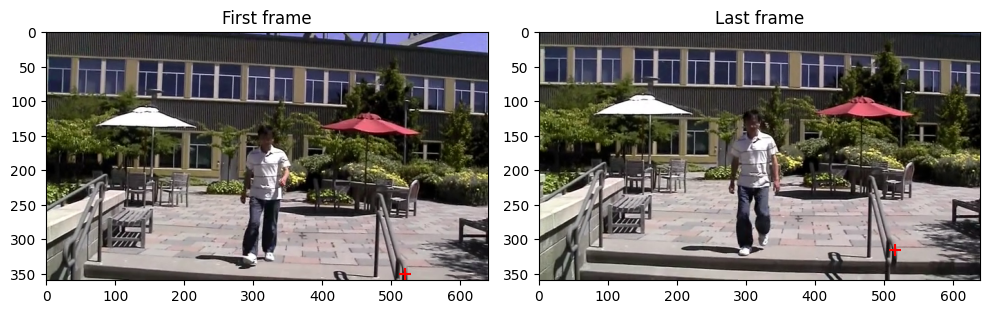

In [ ]:
start_y = pos_y = 350    # Row in the first image
start_x = pos_x = 520    # Column in the first image
t_first = 60
t_steps = 10

positions_x = []
positions_y = []


for i in range(t_steps):
    pass
    # Your code tracking point from first image to last (save this to pos_x,pos_y)
    # TODO remove this code
    pos_x += flows_uv[t_first+i][pos_y,pos_x,0]; pos_x = int(pos_x)
    pos_y += flows_uv[t_first+i][pos_y,pos_x,1]; pos_y = int(pos_y)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,10), dpi=100)
ax1.imshow(frames[t_first][...,::-1])
ax1.scatter(start_x, start_y, marker='+', c='red',s=80)
ax1.set_title("First frame")
ax2.imshow(frames[t_first + t_steps][...,::-1])
ax2.scatter(pos_x, pos_y, marker='+', c='red',s=80)
ax2.set_title("Last frame")
fig.tight_layout()

In [ ]:
unstable_pixel_profiles = np.cumsum(flows_uv, axis=0)

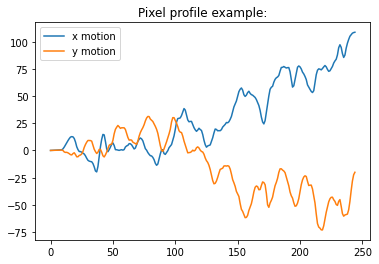

In [ ]:
plt.plot(unstable_pixel_profiles[:, 40,50,0], label="x motion")
plt.plot(unstable_pixel_profiles[:, 40,50,1], label="y motion")
plt.title("Pixel profile example:")
plt.legend()
plt.show()

In [ ]:
def compute_stable_pixel_profiles(
    unstable_pixel_profiles: np.ndarray,
    flows_uv: np.ndarray,
    n_iters=10,
    coef=10,
    window_size=30,
):
    stable_pixel_profiles = unstable_pixel_profiles.copy()

    for i in tqdm(range(n_iters)):
        new_stable_pixel_profiles = np.zeros_like(stable_pixel_profiles)
        for t in tqdm(range(len(flows_uv)), leave=False):
            offsets = np.concatenate((-np.arange(1,window_size//2+1)[::-1],np.arange(1,window_size//2+1)))
            offsets = offsets[(offsets + t > 0) & (offsets + t < stable_pixel_profiles.shape[0])]
            weights = np.exp(-(offsets)**2 / (offsets.shape[0] / 3)**2)
            gamma = 1 + coef * weights.sum()

            new_stable_pixel_profiles[t] = (
                unstable_pixel_profiles[t]
            + coef * (stable_pixel_profiles[offsets + t] * weights[:,None,None,None]).sum(axis=0)
            ) / gamma

        stable_pixel_profiles = new_stable_pixel_profiles

    return stable_pixel_profiles

In [ ]:
stable_pixel_profiles = compute_stable_pixel_profiles(unstable_pixel_profiles, flows_uv)

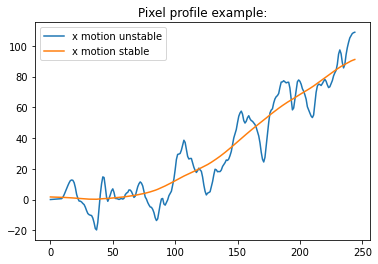

In [ ]:
plt.plot(unstable_pixel_profiles[:, 40,50,0], label="x motion unstable")
plt.plot(stable_pixel_profiles[:, 40,50,0], label="x motion stable")
plt.title("Pixel profile example:")
plt.legend()
plt.show()

In [ ]:
stable_flow_warp = unstable_pixel_profiles - stable_pixel_profiles

In [ ]:
stable_frames = []
for i in tqdm(range(len(stable_flow_warp) - 1)):
    warp = stable_flow_warp[i]

    x = np.arange(warp.shape[1])
    y = np.arange(warp.shape[0])
    xy = np.stack(np.meshgrid(x,y),axis=-1)
    map_xy = (xy + warp).astype(np.float32)
    stable_frames.append(cv2.remap(frames[i], map_xy[...,0], map_xy[...,1], cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT))

In [ ]:
shaky_vs_stable = [np.concatenate([frames[i], stable_frames[i]], axis=1) for i in range(len(stable_frames))]
write_video("side_by_side.mp4", shaky_vs_stable, 30)

In [ ]:
play_video("side_by_side.mp4", width=800)